In [1]:
!pip install catboost

In [2]:
!pip install lightgbm

In [3]:
!pip install xgboost

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import statistics

In [5]:
X_train=pd.read_csv('X_train.csv')
X_test=pd.read_csv('X_test.csv')
y_train=pd.read_csv('y_train.csv')

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199861 entries, 0 to 1199860
Data columns (total 45 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1199861 non-null  int64  
 1   acc_now_delinq              1199861 non-null  float64
 2   addr_state                  1199861 non-null  object 
 3   annual_inc                  1199861 non-null  float64
 4   chargeoff_within_12_mths    1199824 non-null  float64
 5   collections_12_mths_ex_med  1199824 non-null  float64
 6   delinq_2yrs                 1199861 non-null  float64
 7   dti                         1199861 non-null  float64
 8   earliest_cr_line            1199861 non-null  object 
 9   emp_length                  1128114 non-null  object 
 10  fico_range_high             1199861 non-null  float64
 11  fico_range_low              1199861 non-null  float64
 12  funded_amnt                 1199861 non-null  float64
 1

In [7]:
X_train.T

,0,1,2,3,4,5,6,7,8,9,...,1199851,1199852,1199853,1199854,1199855,1199856,1199857,1199858,1199859,1199860
index,0,1,2,3,4,5,6,7,8,9,...,1199851,1199852,1199853,1199854,1199855,1199856,1199857,1199858,1199859,1199860
acc_now_delinq,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
addr_state,UT,CA,NV,AZ,OH,TX,WA,FL,MA,MD,...,TX,CA,OH,TX,CA,IL,NY,MA,OH,TX
annual_inc,80000.0,82000.0,46080.0,30000.0,70000.0,69454.0,78000.0,55000.0,60000.0,65000.0,...,47500.0,49000.0,43000.0,50000.0,120000.0,41000.0,95000.0,61000.0,35000.0,70000.0
chargeoff_within_12_mths,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
collections_12_mths_ex_med,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delinq_2yrs,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
dti,30.49,7.0,17.32,7.8,13.36,7.6,10.82,17.11,7.79,22.77,...,31.18,23.39,29.33,10.11,23.45,22.97,25.63,15.58,24.07,15.05
earliest_cr_line,Oct-1996,Mar-1993,Nov-2000,Jan-2010,Jan-2002,Apr-1993,Apr-2001,Sep-1995,Nov-1991,Sep-1996,...,Sep-1992,May-1995,May-1998,Jul-1999,May-2001,Feb-2002,Jan-2002,Nov-2002,Nov-1991,Sep-2007
emp_length,4 years,10+ years,3 years,< 1 year,< 1 year,10+ years,5 years,3 years,10+ years,10+ years,...,10+ years,3 years,5 years,10+ years,10+ years,4 years,3 years,8 years,5 years,2 years


In [8]:
y_train

,index,loan_status
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0
...,...,...
1199856,1199856,0
1199857,1199857,0
1199858,1199858,0
1199859,1199859,0


1. Каков процент дефолтных ("плохих") займов для ZIP кодов штата Коннектикут в проверочной выборке (X_train.csv)?

In [9]:
count_bad=0
count=0
X_train_len=len(X_train.axes[0])
for i in range(0,X_train_len):
    if X_train['addr_state'].loc[i]=='CT':
        count+=1
        if y_train['loan_status'].loc[i]==1:
            count_bad+=1
print(count_bad/count)

0.1752242584337681


2.1.В тестовой выборке в 3 раза больше займов, выданных на 3 года, чем на 5 лет

In [10]:
num_36 = len(X_train[X_train['term'].str.contains('36')])
num_60=X_train_len-num_36
num_36/num_60

3.0513671571639844

2.2. Медианная процентная ставка в трейне (X_train.csv) 16.29%

In [11]:
statistics.median(X_train['int_rate'])

' 12.69%'

2.3 Последний займ выдан в августе 2020 года

In [12]:
X_train['issue_d'].max()

'Sep-2020'

In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
index,1199861.0,599930.000000,346370.180008,0.00,299965.00,599930.00,899895.00,1.199860e+06
acc_now_delinq,1199861.0,0.004626,0.072842,0.00,0.00,0.00,0.00,6.000000e+00
annual_inc,1199861.0,78110.512218,136351.414907,2300.00,47000.00,65000.00,93000.00,1.100000e+08
chargeoff_within_12_mths,1199824.0,0.008901,0.108155,0.00,0.00,0.00,0.00,1.000000e+01
collections_12_mths_ex_med,1199824.0,0.018102,0.150731,0.00,0.00,0.00,0.00,2.000000e+01
delinq_2yrs,1199861.0,0.314226,0.876369,0.00,0.00,0.00,0.00,4.200000e+01
dti,1199861.0,18.038746,8.404678,-1.00,11.74,17.55,23.97,4.996000e+01
fico_range_high,1199861.0,701.200282,32.341045,664.00,674.00,694.00,719.00,8.500000e+02
fico_range_low,1199861.0,697.200134,32.340365,660.00,670.00,690.00,715.00,8.450000e+02
funded_amnt,1199861.0,14404.663894,8855.222599,500.00,7675.00,12000.00,20000.00,4.000000e+04


In [14]:
train_df=pd.concat([X_train,y_train],axis=1)
train_df

,index,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,...,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code,index,loan_status
0,0,0.0,UT,80000.0,0.0,0.0,0.0,30.49,Oct-1996,4 years,...,credit_card,56.1%,0.0,36 months,Credit card refinancing,26.0,Source Verified,847xx,0,1
1,1,0.0,CA,82000.0,0.0,0.0,0.0,7.00,Mar-1993,10+ years,...,credit_card,88.3%,0.0,36 months,Credit card refinancing,11.0,Not Verified,900xx,1,0
2,2,0.0,NV,46080.0,0.0,0.0,1.0,17.32,Nov-2000,3 years,...,credit_card,18.1%,0.0,36 months,Credit card refinancing,31.0,Source Verified,895xx,2,1
3,3,0.0,AZ,30000.0,0.0,0.0,0.0,7.80,Jan-2010,< 1 year,...,car,33.4%,0.0,36 months,Car financing,24.0,Source Verified,853xx,3,0
4,4,0.0,OH,70000.0,0.0,0.0,0.0,13.36,Jan-2002,< 1 year,...,other,88.6%,0.0,60 months,Other,16.0,Not Verified,453xx,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199856,1199856,0.0,IL,41000.0,0.0,0.0,0.0,22.97,Feb-2002,4 years,...,debt_consolidation,82.1%,0.0,36 months,debt consolidation,8.0,Source Verified,604xx,1199856,0
1199857,1199857,0.0,NY,95000.0,0.0,0.0,0.0,25.63,Jan-2002,3 years,...,credit_card,82.3%,0.0,36 months,Credit cards financing,29.0,Verified,106xx,1199857,0
1199858,1199858,0.0,MA,61000.0,0.0,0.0,0.0,15.58,Nov-2002,8 years,...,home_improvement,6%,0.0,60 months,Home improvement,26.0,Source Verified,021xx,1199858,0
1199859,1199859,0.0,OH,35000.0,0.0,0.0,0.0,24.07,Nov-1991,5 years,...,debt_consolidation,76.2%,0.0,60 months,Debt,52.0,Verified,454xx,1199859,0


2.4. Дефолт для 10% самых богатых выше, чем у остальных

In [15]:
richest = train_df.sort_values('annual_inc')[:119986]
poorest=train_df.sort_values('annual_inc')[119986:]
print(len(richest[richest['loan_status']==1])/len(richest.axes[0]))
print(len(poorest[poorest['loan_status']==1])/len(poorest.axes[0]))

0.2279182571299985
0.18915244820002314


3.1 Доля проблемных счетов (т.е. acc_now_delinq>0) примерно одна и та же (для дефолтных и недефолтных займов)

In [16]:
def_df=train_df[train_df['loan_status']==1] 
no_def_df=train_df[train_df['loan_status']==0] 
print(len(def_df[def_df['acc_now_delinq']>0])/len(def_df.axes[0]))
print(len(no_def_df[no_def_df['acc_now_delinq']>0])/len(no_def_df.axes[0]))

0.00449034575662326
0.004298463314856758


3.2 Нижний порог от бюро кредитных историй (fico_range_low) не существенно отличается для плохих и хороших

In [17]:
def_df['fico_range_low'].describe()

count    231608.000000
mean        689.052688
std          26.710361
min         660.000000
25%         670.000000
50%         680.000000
75%         700.000000
max         845.000000
Name: fico_range_low, dtype: float64

In [18]:
no_def_df['fico_range_low'].describe()

count    968253.000000
mean        699.149019
std          33.252781
min         660.000000
25%         675.000000
50%         690.000000
75%         715.000000
max         845.000000
Name: fico_range_low, dtype: float64

3.3 Плохие и хорошие не отличаются по разнице между средней запрошенной и одобренной суммой

In [19]:
# funded_amnt -дали and loan_amnt - просили
def_df['loan-fun']=[def_df['loan_amnt'].iloc[i]-def_df['funded_amnt'].iloc[i] for i in range(len(def_df.axes[0]))]
def_df['loan-fun'].describe()

C:\Users\Юля\AppData\Local\Temp\ipykernel_12612\3696155592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def_df['loan-fun']=[def_df['loan_amnt'].iloc[i]-def_df['funded_amnt'].iloc[i] for i in range(len(def_df.axes[0]))]


count    231608.000000
mean          6.230679
std         221.156075
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       16200.000000
Name: loan-fun, dtype: float64

In [20]:
no_def_df['loan-fun']=[no_def_df['loan_amnt'].iloc[i]-no_def_df['funded_amnt'].iloc[i] for i in range(len(no_def_df.axes[0]))]
no_def_df['loan-fun'].describe()

C:\Users\Юля\AppData\Local\Temp\ipykernel_12612\3674592604.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_def_df['loan-fun']=[no_def_df['loan_amnt'].iloc[i]-no_def_df['funded_amnt'].iloc[i] for i in range(len(no_def_df.axes[0]))]


count    968253.000000
mean          6.250794
std         221.114654
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       20600.000000
Name: loan-fun, dtype: float64

3.4. Доли пропущенных значений в mths_since_recent_bc_dlq для плохих и хороших отличаются значимо

In [21]:
def_df['mths_since_recent_bc_dlq'].isnull().sum()/len(def_df.axes[0])

0.7547234983247556

In [22]:
no_def_df['mths_since_recent_bc_dlq'].isnull().sum()/len(no_def_df.axes[0])

0.7667376191966356

4.2. Тем, у кого провели верификацию дохода, доход больше

In [23]:
X_train[X_train['verification_status']=='Source Verified']['annual_inc'].describe()

count    4.787090e+05
mean     8.225557e+04
std      1.306340e+05
min      2.300000e+03
25%      4.800000e+04
50%      6.700000e+04
75%      9.600000e+04
max      6.100000e+07
Name: annual_inc, dtype: float64

In [24]:
X_train[X_train['verification_status']=='Not Verified']['annual_inc'].describe()

count    3.771330e+05
mean     7.217387e+04
std      4.517524e+04
min      3.400000e+03
25%      4.600000e+04
50%      6.500000e+04
75%      8.900000e+04
max      8.250000e+06
Name: annual_inc, dtype: float64

4.3 Tем, у кого провели верификацию дохода, дефолт меньше

In [25]:
train_df[train_df['verification_status']=='Source Verified']['loan_status'].describe()

count    478709.000000
mean          0.200172
std           0.400129
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: loan_status, dtype: float64

In [26]:
train_df[train_df['verification_status']=='Not Verified']['loan_status'].describe()

count    377133.000000
mean          0.149061
std           0.356150
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: loan_status, dtype: float64

5. На сколько уменьшится доля дефолта, если выдавать только тем, у кого есть хоть одна ипотека (mort_acc > 0) и приемлемое отношение долгов к доходу (dti < 0.3).

In [27]:
mort_and_low_dti = train_df[train_df['mort_acc']>0][train_df[train_df['mort_acc']>0]['dti']<0.3]
per_m_and_d=len(mort_and_low_dti[mort_and_low_dti['loan_status']==1])/len(mort_and_low_dti)
per_tr=len(train_df[train_df['loan_status']==1])/len(train_df)
print(per_tr-per_m_and_d)

0.04908963192276841


8. Какой признак сделать из emp_length и другого категориального признака с 15 или менее категориями, чтобы доля дефолта была наибольшая?

In [28]:
df_emp8=train_df[train_df['emp_length']=='8 years']
df_emp8_home=df_emp8[df_emp8['home_ownership']=='RENT']
len(df_emp8_home[df_emp8_home['loan_status']==1])/len(df_emp8_home)

0.22932756667696427

In [29]:
df_emp4=train_df[train_df['emp_length']=='4 years']
df_emp4_pur=df_emp4[df_emp4['purpose']=='small_business']
len(df_emp4_pur[df_emp4_pur['loan_status']==1])/len(df_emp4_pur)

0.31262939958592134

In [30]:
df_emp1=train_df[train_df['emp_length']=='1 year']
df_emp1_term=df_emp1[df_emp1['term'].str.contains('60')]
len(df_emp1_term[df_emp1_term['loan_status']==1])/len(df_emp1_term)

0.33508939079751165

In [31]:
df_emp3=train_df[train_df['emp_length']=='3 years']
df_emp3_ver=df_emp3[df_emp3['verification_status']=='Verified']
len(df_emp3_ver[df_emp3_ver['loan_status']==1])/len(df_emp3_ver)

0.2350654084484225

Убираем неиформативные признаки, остальные преобразуем

In [32]:
print(X_train[~X_train.applymap(np.isreal).all(1)])
null_columns=X_train.columns[X_train.isnull().any()]
print(X_train[X_train.isnull().any(axis=1)][null_columns].head())

           index  acc_now_delinq addr_state  annual_inc  \
0              0             0.0         UT     80000.0   
1              1             0.0         CA     82000.0   
2              2             0.0         NV     46080.0   
3              3             0.0         AZ     30000.0   
4              4             0.0         OH     70000.0   
...          ...             ...        ...         ...   
1199856  1199856             0.0         IL     41000.0   
1199857  1199857             0.0         NY     95000.0   
1199858  1199858             0.0         MA     61000.0   
1199859  1199859             0.0         OH     35000.0   
1199860  1199860             0.0         TX     70000.0   

         chargeoff_within_12_mths  collections_12_mths_ex_med  delinq_2yrs  \
0                             0.0                         0.0          0.0   
1                             0.0                         0.0          0.0   
2                             0.0                        

In [33]:
X_train['acc_now_delinq'].describe()

count    1.199861e+06
mean     4.625536e-03
std      7.284156e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: acc_now_delinq, dtype: float64

In [34]:
labels_to_kill=['index','addr_state','term','title','zip_code']
string_labels=['purpose','verification_status','home_ownership'] 
labels_to_kill

['index', 'addr_state', 'term', 'title', 'zip_code']

In [35]:
X_train = X_train.drop(labels_to_kill,axis=1)
indexes=X_test['index']
X_test = X_test.drop(labels_to_kill,axis=1)
y_train = y_train.drop(['index'], axis=1)

In [36]:
X_train['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line']).sub(pd.Timestamp('1930-01-01')).dt.days.astype(float)
X_test['earliest_cr_line'] = pd.to_datetime(X_train['earliest_cr_line']).sub(pd.Timestamp('1930-01-01')).dt.days.astype(float)

In [37]:
for df in [X_test,X_train]:
    df['emp_length']= df['emp_length'].apply(lambda x: str(x).replace('10+ ','10 '))
    df['emp_length'] = df['emp_length'].apply(lambda x: x.replace('years',''))
    df['emp_length']= df['emp_length'].apply(lambda x: x.replace('year',''))
    df['emp_length']= df['emp_length'].apply(lambda x: x.replace('<',''))
    df['emp_length'] = df['emp_length'].astype(float)

In [38]:
for df in [X_train,X_test]:
    df['int_rate'] = df['int_rate'].apply(lambda x: float(str(x).replace('%',''))/100.0)
    df['revol_util'] = df['revol_util'].apply(lambda x: float(str(x).replace('%',''))/100.0)

In [39]:
X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

In [40]:
pd.to_datetime(X_train['issue_d']).dt.year

0          2016
1          2017
2          2016
3          2015
4          2017
           ... 
1199856    2012
1199857    2013
1199858    2015
1199859    2012
1199860    2015
Name: issue_d, Length: 1199861, dtype: int64

In [41]:
X_train['issue_d']=pd.to_datetime(X_train['issue_d']).dt.year
X_test['issue_d']=pd.to_datetime(X_test['issue_d']).dt.year

Преобразование категориальных признаков

In [42]:
onehotencoder=OneHotEncoder()
for df in [X_train,X_test]:
    for x in string_labels:
        df[x]=onehotencoder.fit_transform(df[x].array.reshape(-1, 1)).toarray()

Разбиваем обучающую выборку на 2

In [43]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.33, random_state=100)

In [44]:
X_train2

,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,fico_range_low,...,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,total_acc,verification_status
471986,0.0,72000.0,0.0,0.0,0.0,4.93,29828.0,1.0,704.0,700.0,...,0.0,3.0,40.0,0.0,0.0,0.0,0.514,0.0,10.0,0.0
1059996,0.0,48000.0,0.0,0.0,0.0,10.45,25383.0,8.0,684.0,680.0,...,-999.0,-999.0,75.0,0.0,0.0,1.0,0.799,0.0,14.0,0.0
1170907,0.0,41000.0,0.0,0.0,0.0,34.07,26206.0,2.0,684.0,680.0,...,-999.0,-999.0,100.0,0.0,0.0,0.0,0.554,0.0,38.0,0.0
15303,0.0,62000.0,0.0,0.0,1.0,19.28,24531.0,10.0,669.0,665.0,...,-999.0,-999.0,60.0,0.0,0.0,1.0,0.461,0.0,17.0,0.0
64,0.0,110000.0,0.0,0.0,1.0,7.22,27059.0,10.0,674.0,670.0,...,-999.0,-999.0,33.3,0.0,0.0,1.0,0.634,0.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212912,0.0,80000.0,0.0,0.0,1.0,11.00,26479.0,2.0,669.0,665.0,...,-999.0,-999.0,100.0,0.0,0.0,1.0,0.883,0.0,13.0,0.0
65615,0.0,38000.0,0.0,0.0,0.0,21.63,25964.0,10.0,699.0,695.0,...,-999.0,-999.0,-999.0,0.0,0.0,0.0,0.938,0.0,19.0,0.0
864087,0.0,20000.0,0.0,0.0,0.0,14.35,24806.0,-999.0,719.0,715.0,...,0.0,3.0,-999.0,1.0,1.0,0.0,0.449,0.0,14.0,0.0
210755,0.0,49000.0,0.0,0.0,0.0,10.26,25353.0,10.0,669.0,665.0,...,-999.0,-999.0,50.0,1.0,1.0,1.0,0.483,0.0,36.0,0.0


Дерево решений

[Text(0.4539453601953602, 0.9545454545454546, 'int_rate <= 0.132\ngini = 0.311\nsamples = 803906\nvalue = [648786, 155120]'),
 Text(0.19293727106227107, 0.8636363636363636, 'int_rate <= 0.094\ngini = 0.209\nsamples = 441320\nvalue = [389051, 52269]'),
 Text(0.08704403235653235, 0.7727272727272727, 'int_rate <= 0.078\ngini = 0.134\nsamples = 190536\nvalue = [176832, 13704]'),
 Text(0.039854242979242976, 0.6818181818181818, 'int_rate <= 0.06\ngini = 0.102\nsamples = 100364\nvalue = [94979, 5385]'),
 Text(0.0173992673992674, 0.5909090909090909, 'fico_range_high <= 736.5\ngini = 0.062\nsamples = 26196\nvalue = [25358, 838]'),
 Text(0.00847069597069597, 0.5, 'issue_d <= 2017.5\ngini = 0.083\nsamples = 9693\nvalue = [9271, 422]'),
 Text(0.0028998778998779, 0.4090909090909091, 'dti <= 0.28\ngini = 0.077\nsamples = 9033\nvalue = [8669, 364]'),
 Text(0.001221001221001221, 0.3181818181818182, 'percent_bc_gt_75 <= -499.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.0006105006105006105, 0

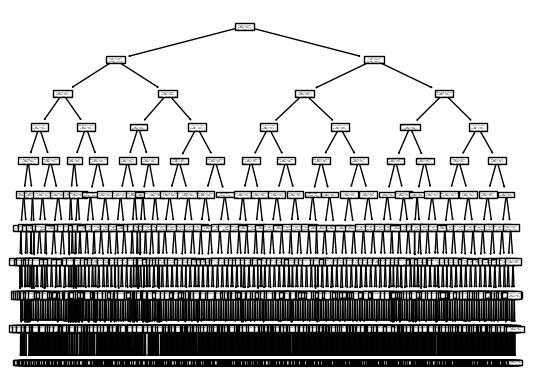

In [45]:
tree_clf = DecisionTreeClassifier(random_state=0,max_depth = 10).fit(X_train2, y_train2)
tree.plot_tree(tree_clf,feature_names=X_train2.columns)

In [46]:
print(tree_clf.predict_proba(X_test2))
accuracy = tree_clf.score(X_test2,y_test2)
print(accuracy)

[[0.89316575 0.10683425]
 [0.5255418  0.4744582 ]
 [0.60121049 0.39878951]
 ...
 [0.91936375 0.08063625]
 [0.88953115 0.11046885]
 [0.6572935  0.3427065 ]]
0.8058188430503467


In [47]:
logit_roc_auc = roc_auc_score(y_test2, tree_clf.predict(X_test2))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test2, tree_clf.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)
GINI = (2 * roc_auc) - 1
print(GINI)

0.5172941282791202
0.39886869056499474


Случайный лес

In [48]:
rand_clf = RandomForestClassifier(max_depth=10, min_samples_leaf=100,n_jobs=-1)
rand_clf.fit(X_train2, y_train2)
print('done')

C:\Users\Юля\AppData\Local\Temp\ipykernel_12612\3954308201.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand_clf.fit(X_train2, y_train2)


done


In [49]:
print(rand_clf.predict_proba(X_test2))
accuracy = rand_clf.score(X_test2,y_test2)
print(accuracy)

[[0.86377429 0.13622571]
 [0.68121665 0.31878335]
 [0.67563717 0.32436283]
 ...
 [0.91159689 0.08840311]
 [0.91222734 0.08777266]
 [0.78273142 0.21726858]]
0.8069603869126543


In [50]:
logit_roc_auc = roc_auc_score(y_test2, rand_clf.predict(X_test2))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test2, rand_clf.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)
GINI = (2 * roc_auc) - 1
print(GINI)

0.5006099684860156
0.421182107895095


LogisticRegression

In [51]:
log_reg = LogisticRegression(solver='newton-cholesky')
log_reg.fit(X_train2, y_train2)

C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.33511e-18): result may not be accurate.
  warnings.warn(
C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm

LogisticRegression(solver='newton-cholesky')

In [52]:
print(log_reg.predict_proba(X_test2))
accuracy = log_reg.score(X_test2,y_test2)
print(accuracy)

[[0.79566244 0.20433756]
 [0.780555   0.219445  ]
 [0.79818395 0.20181605]
 ...
 [0.85479847 0.14520153]
 [0.8565691  0.1434309 ]
 [0.76692555 0.23307445]]
0.8067709714487757


In [53]:
logit_roc_auc = roc_auc_score(y_test2, log_reg.predict(X_test2))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test2, log_reg.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)
GINI = (2 * roc_auc) - 1
print(GINI)

0.5005224166673623
0.25026629022475655


Catboost

In [54]:
catboost = CatBoostClassifier(iterations=80)
catboost.fit(X_train2, y_train2)

Learning rate set to 0.5
0:	learn: 0.5042758	total: 268ms	remaining: 21.2s
1:	learn: 0.4659124	total: 371ms	remaining: 14.5s
2:	learn: 0.4545205	total: 484ms	remaining: 12.4s
3:	learn: 0.4512262	total: 590ms	remaining: 11.2s
4:	learn: 0.4494512	total: 719ms	remaining: 10.8s
5:	learn: 0.4482830	total: 851ms	remaining: 10.5s
6:	learn: 0.4472594	total: 972ms	remaining: 10.1s
7:	learn: 0.4463067	total: 1.09s	remaining: 9.84s
8:	learn: 0.4457071	total: 1.21s	remaining: 9.54s
9:	learn: 0.4451603	total: 1.31s	remaining: 9.18s
10:	learn: 0.4447466	total: 1.42s	remaining: 8.9s
11:	learn: 0.4444746	total: 1.53s	remaining: 8.7s
12:	learn: 0.4441940	total: 1.64s	remaining: 8.45s
13:	learn: 0.4438142	total: 1.75s	remaining: 8.24s
14:	learn: 0.4433606	total: 1.88s	remaining: 8.16s
15:	learn: 0.4431363	total: 2.01s	remaining: 8.03s
16:	learn: 0.4429418	total: 2.12s	remaining: 7.87s
17:	learn: 0.4427458	total: 2.24s	remaining: 7.7s
18:	learn: 0.4425501	total: 2.33s	remaining: 7.48s
19:	learn: 0.442322

In [55]:
accuracy =catboost.score(X_test2,y_test2)
print(accuracy)

0.8100566983621876


In [56]:
logit_roc_auc = roc_auc_score(y_test2, catboost.predict(X_test2))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test2, catboost.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)
GINI = (2 * roc_auc) - 1
print(GINI)

0.5315495727582825
0.4436629912113117


Lightgb (the_best)

In [57]:
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train2, y_train2)

C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 155120, number of negative: 648786
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3161
[LightGBM] [Info] Number of data points in the train set: 803906, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192958 -> initscore=-1.430904
[LightGBM] [Info] Start training from score -1.430904


LGBMClassifier()

In [58]:
accuracy =lgb_clf.score(X_test2,y_test2)
print(accuracy)

0.8102940990769153


0.5265209800505014
0.44314607770921777


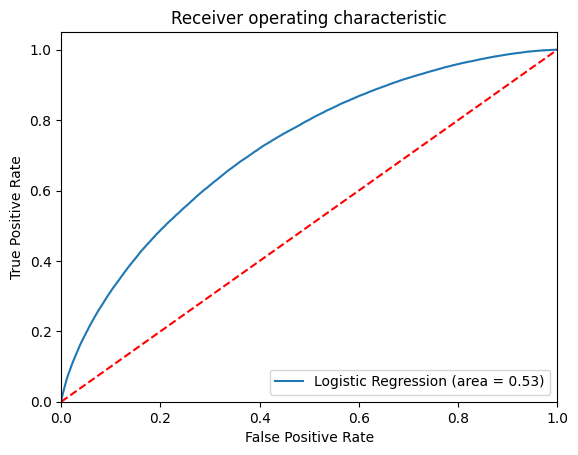

In [59]:
logit_roc_auc = roc_auc_score(y_test2, lgb_clf.predict(X_test2))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test2, lgb_clf.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)
GINI = (2 * roc_auc) - 1
print(GINI)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Xgboost

In [60]:
xgb_clf =XGBClassifier(n_estimators=250, learning_rate=0.10, colsample_bytree=0.70, max_depth=3)
xgb_clf.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
accuracy =xgb_clf.score(X_test2,y_test2)
print(accuracy)

0.8099152681491584


In [62]:
logit_roc_auc = roc_auc_score(y_test2, xgb_clf.predict(X_test2))
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test2, xgb_clf.predict_proba(X_test2)[:,1])
roc_auc = auc(fpr, tpr)
GINI = (2 * roc_auc) - 1
print(GINI)

0.5227263577913357
0.4401786664514562


10. Нужно ли строить отдельную модель catboost для каждого года?

In [63]:
tr_df=pd.concat([X_train2,y_train2],axis=1)
ts_df=pd.concat([X_test2,y_test2],axis=1)
for i in range(2007,2021):
    X_tr= tr_df[tr_df['issue_d'] == i].drop(['loan_status'], axis=1)
    X_ts=ts_df[ts_df['issue_d'] == i].drop(['loan_status'], axis=1)
    y_tr=tr_df[tr_df['issue_d'] == i]['loan_status']
    y_ts=ts_df[ts_df['issue_d'] == i]['loan_status']
    catboost.fit(X_tr, y_tr,verbose=False)
    logit_roc_auc = roc_auc_score(y_ts, catboost.predict(X_ts))
    print(i)
    print(logit_roc_auc)
    fpr, tpr, thresholds = roc_curve(y_ts, catboost.predict_proba(X_ts)[:,1])
    roc_auc = auc(fpr, tpr)
    GINI = (2 * roc_auc) - 1
    print(GINI)                                                         

2007
0.47674418604651164
0.5983086680761098
2008
0.5214991657040174
0.16300859966628156
2009
0.5058960263327564
0.1784756863144321
2010
0.505045000703136
0.31244726480101237
2011
0.5180439697593517
0.33831105924833227
2012
0.5189372396649995
0.3271200506842613
2013
0.5107996256528954
0.3435781237579345
2014
0.5134409060295856
0.3840525286818661
2015
0.5346630898281924
0.4351273913385585
2016
0.54078053860185
0.4349832311864448
2017
0.5425062365545934
0.4367797131396576
2018
0.5629392308186779
0.4501697003732088
2019
0.5395224434417126
0.42189894191223565
2020
0.5
0.3266267465069861


In [64]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199861 entries, 0 to 1199860
Data columns (total 40 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   acc_now_delinq              1199861 non-null  float64
 1   annual_inc                  1199861 non-null  float64
 2   chargeoff_within_12_mths    1199861 non-null  float64
 3   collections_12_mths_ex_med  1199861 non-null  float64
 4   delinq_2yrs                 1199861 non-null  float64
 5   dti                         1199861 non-null  float64
 6   earliest_cr_line            1199861 non-null  float64
 7   emp_length                  1199861 non-null  float64
 8   fico_range_high             1199861 non-null  float64
 9   fico_range_low              1199861 non-null  float64
 10  funded_amnt                 1199861 non-null  float64
 11  home_ownership              1199861 non-null  float64
 12  inq_last_12m                1199861 non-null  float64
 1

In [65]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199861 entries, 0 to 1199860
Data columns (total 1 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   loan_status  1199861 non-null  int64
dtypes: int64(1)
memory usage: 9.2 MB


4.4 Верификация дохода и (loan_amnt - funded_amnt) имеют значительную (>0.5) положительную корреляцию

In [66]:
train_df=pd.concat([X_train,y_train],axis=1)
train_df['loan-fun']=[train_df['loan_amnt'].iloc[i]-train_df['funded_amnt'].iloc[i] for i in range(len(train_df.axes[0]))]

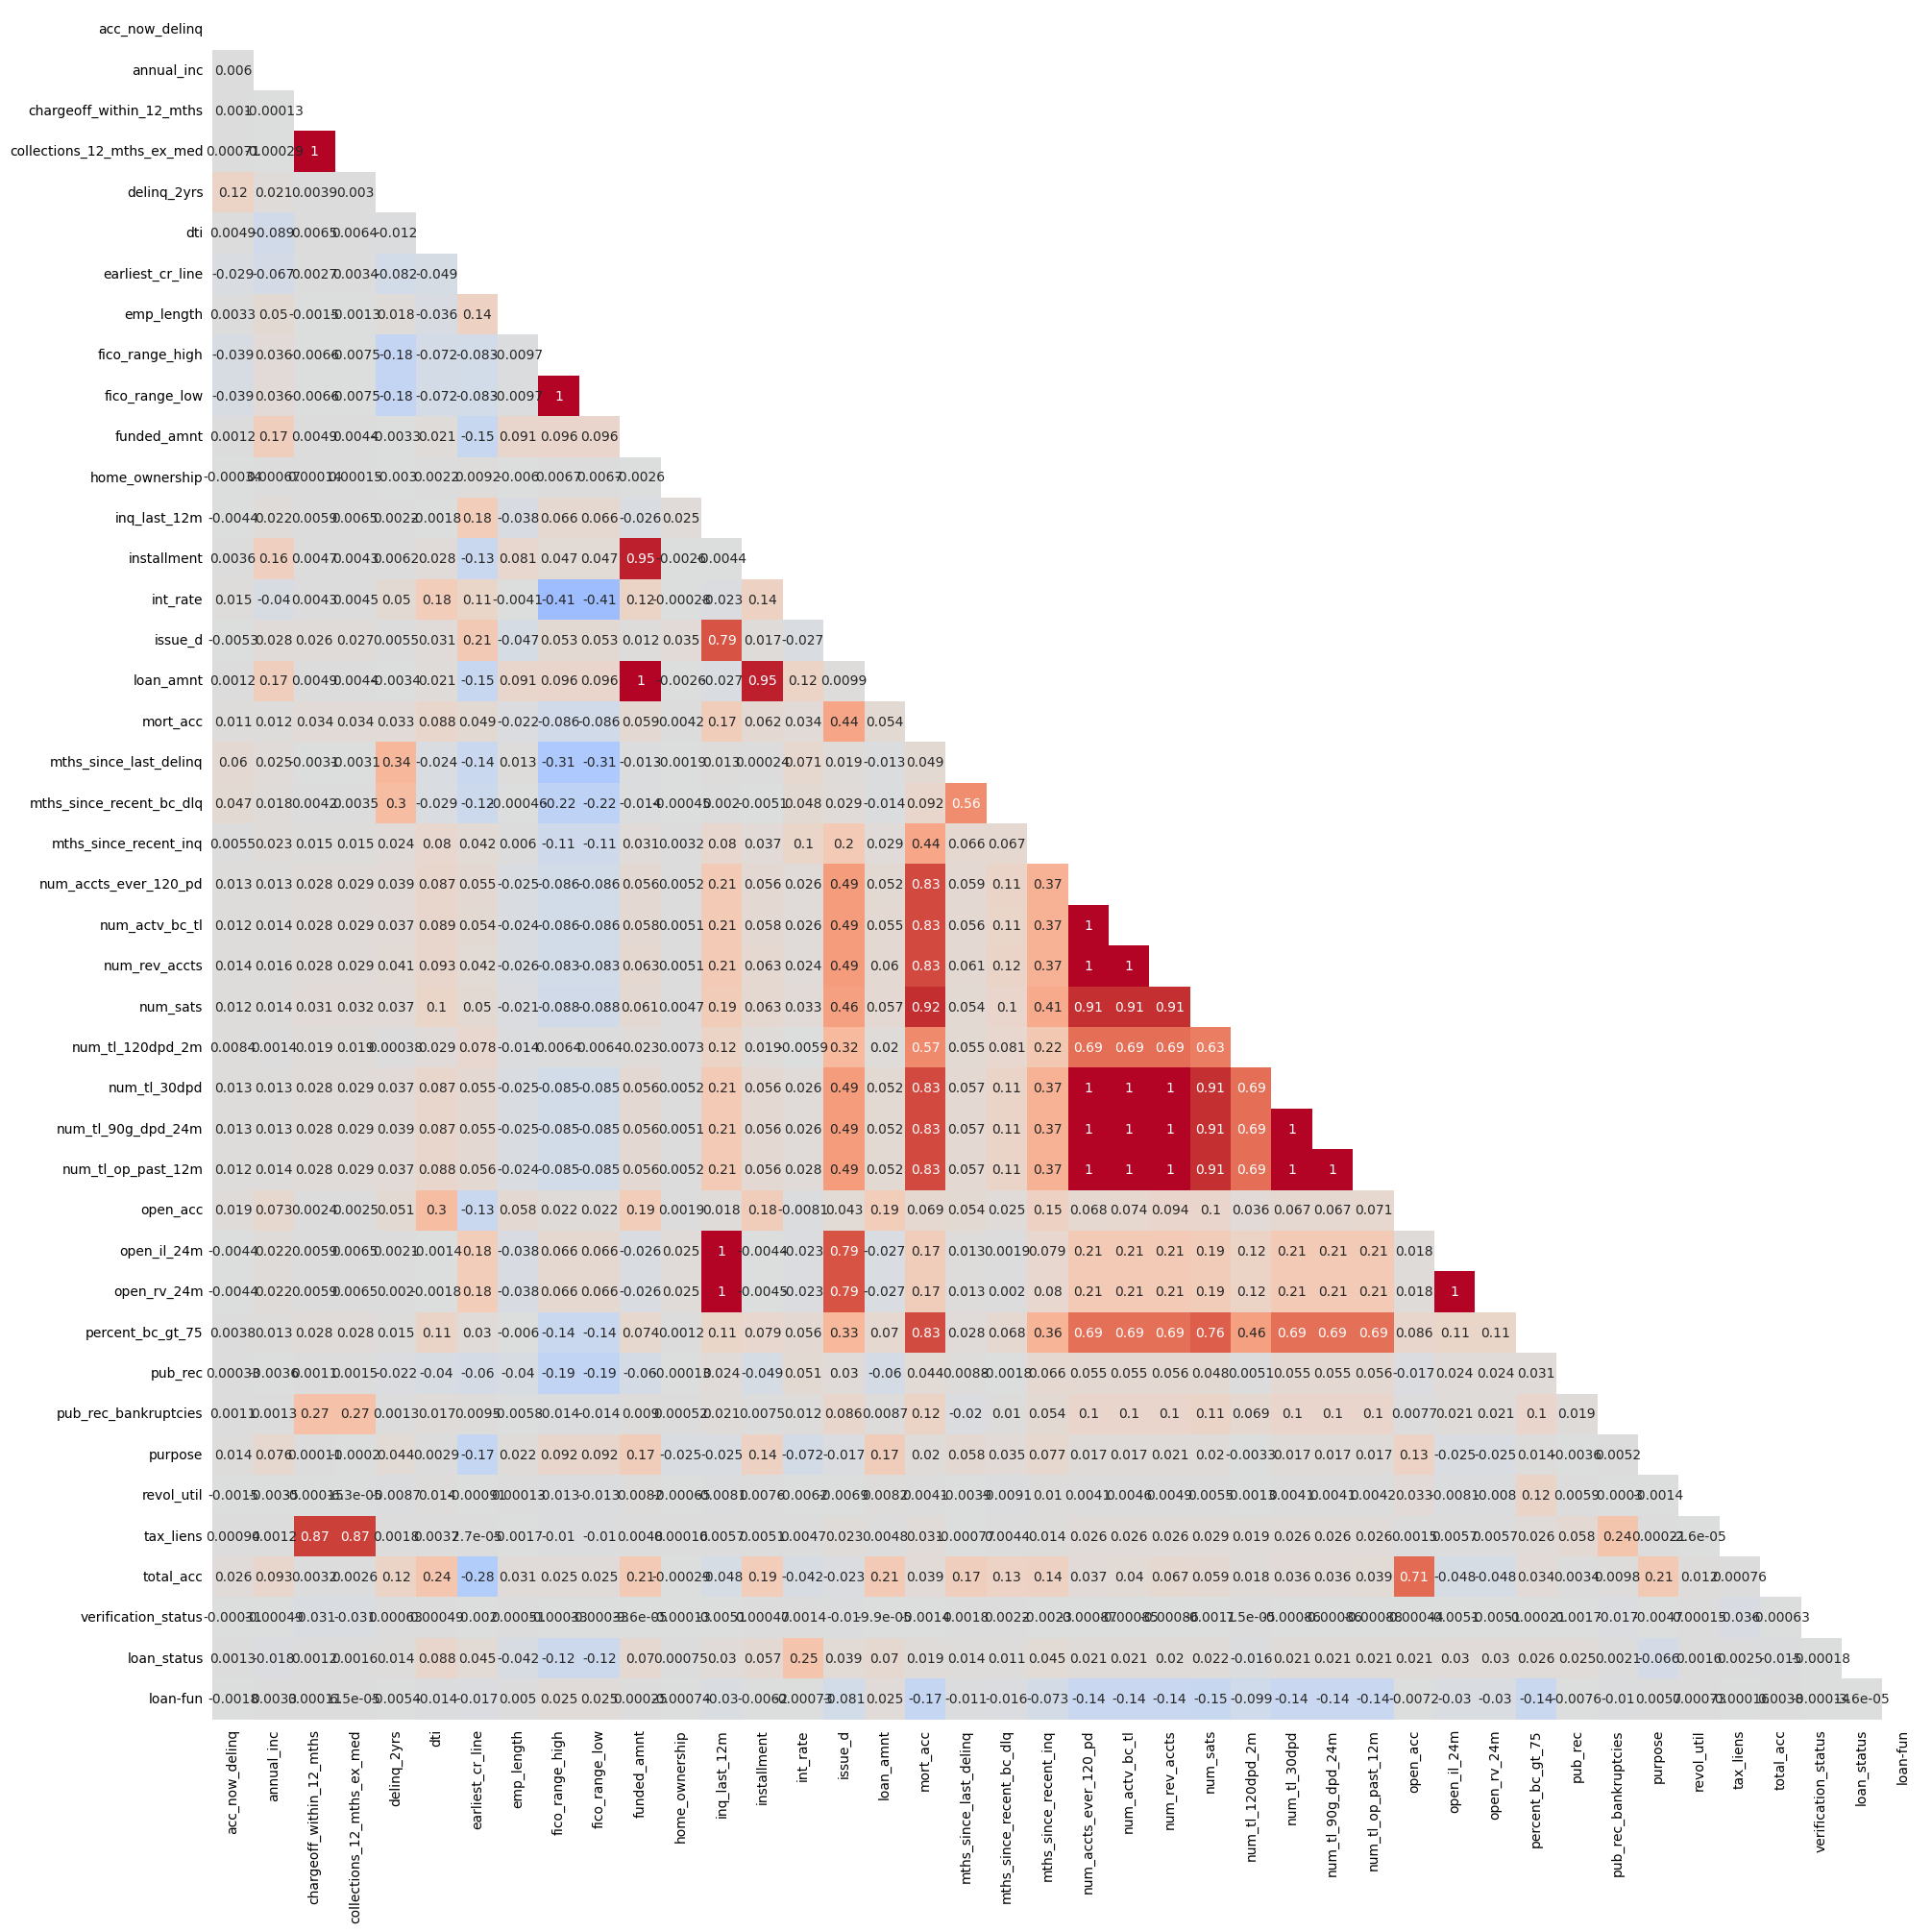

In [67]:
fig, ax = plt.subplots(figsize=(20, 20), constrained_layout=True)
corr_df=train_df
corr =corr_df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cbar=False, mask=mask,ax=ax,annot=True, cmap='coolwarm',vmin=-1,vmax=1)
ax.tick_params(top=False,bottom=False,left=False,right=False,)

In [68]:
lgb_clf.fit(X_train,y_train)
predictions = lgb_clf.predict_proba(X_test)

C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Юля\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 231608, number of negative: 968253
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3165
[LightGBM] [Info] Number of data points in the train set: 1199861, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.193029 -> initscore=-1.430447
[LightGBM] [Info] Start training from score -1.430447


In [69]:
lgb_clf.classes_

array([0, 1], dtype=int64)

In [70]:
output = pd.DataFrame({'index': indexes, 'loan_status':predictions[:,1]})
output.to_csv('answer.csv', index=False)
print('Finished!')

Finished!


Формируем requirements.txt

In [71]:
!pip install pipreqsnb
import pipreqsnb 

In [72]:
!pipreqsnb .

pipreqs  .


Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in .\requirements.txt
